In [85]:
from utils import remove_useless

import pandas as pd
import numpy as np

from transformers import AutoTokenizer

from ast import literal_eval

from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt

import re


In [86]:
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")

In [87]:
df_shorts = pd.read_csv("../dataset/shorts_ids_comments.csv")
df_shorts["list_shorts_comments"] = df_shorts["list_shorts_comments"].apply(literal_eval)
df_shorts["list_origin_comments"] = df_shorts["list_origin_comments"].apply(literal_eval)

df_shorts

,Unnamed: 0,id_shorts,id_origin,list_shorts_comments,list_origin_comments
0,0,Bo7h7a_UOt8,-,"[[아 넹!! 이거 개 킹받는닼ㅋㅋㅋㅋ, @potatogamja12, 2024-01...",[]
1,1,m0g7kcsG9C0,-,"[[이걸 보고 뭘 배울까! 너무한다!, @jinhyukjang9693, 2024-0...",[]
2,2,KksUHOuZW6A,-,"[[&#39;좋은데 간다&#39; 라는 표현이 저 시절에도 썼구나, @user-lr...",[]
3,3,8iJC964vnR8,WrKNUpJN0ZE,[[채널 이름 아래 위치한 <br>&quot;▷ [한글자막] 브라이언에게 먼지가 묻...,"[[Thank you for inviting me, Psick! <br>Happy ..."
4,4,oDCbQ3-24L0,6CxzUf9cnGA,"[[Clip from<br>👉<a href=""https://youtu.be/6Cxz...","[[원훈아, 네가 스피치 강사 해. 숏박스는 내가 맡을게., @uncleFree, ..."
5,5,1m7FODlxUbw,ZQfPKzN45ls,"[[Clip from<br>👉<a href=""https://youtu.be/ZQfP...","[[산골촌놈 서울 구경시켜주셔서 대단히 감사했습니다!<br>숏박스 만쉐이~!!, @..."
6,6,KTpcD8V-h-k,zfONAj_ZZzw,"[[원본 180초 보러가기👉<br><a href=""https://youtu.be/z...","[[와 이런 영상인 줄 모르고봤어 스케줄있다고 핑계대길잘했네, @shortbox, ..."
7,7,74Q9caO6kN0,yDfR-xCVyPU,"[[원본 영상은? 👉<a href=""https://www.youtube.com/wa...",[[탁재훈이랑 수사관이랑 합도 좋고 게스트도 빵빵!!! 요즘 젤 물오른 숏박스라니ㅋ...
8,8,N8rO9Cs3cUA,9bugfmEfp40,"[[동네스타K 시즌2 마지막화 숏박스 완전체 보러가기 👉🏼<a href=""https...","[[조나단 저 날 노팬티였어요 귀엽더라 너, @shortbox, 2022-12-03..."
9,9,MPaLOasgO5U,ImopmYQhx-A,"[[풀버전:<br><a href=""https://youtu.be/ImopmYQhx-...","[[만나서 반가웠어요❤, @haneelee, 2023-04-16T10:41:12Z,..."


In [147]:
# 4번 텍스트 전처리로 오차범위 감소 확인. 
# 4. 5번 홀란드와 아웃백에 관한 설명 감지. 
# 1. 7번 텍스트 전처리로 정답 교정 가능 확인. 
# 2. 9번 단어 이선균과 명복과 같은 공간으로 분류 및 이선균의 죽음에 대한 의견을 클러스터. 
# 10번 도배로 인한 문제 확인. 
# 3. 12번 악플로 인한 문제(쇼츠) 확인. 
# 
# 비판적인 댓글은 분산..? 

pos_video_comment = 15

list_origin_comments = [remove_useless(item[0]) for item in df_shorts["list_origin_comments"].tolist()[pos_video_comment]]
print("Length of raw:", len(list_origin_comments))
list_origin_comments = [item for item in list_origin_comments if len(item) > 5]
list_origin_comments = [item for item in list_origin_comments if ":" in item]
print("Length of filtered:", len(list_origin_comments))

list_shorts_comments = [remove_useless(item[0]) for item in df_shorts["list_shorts_comments"].tolist()[pos_video_comment]]
list_shorts_comments = [item for item in list_shorts_comments if len(item) > 5]

list_origin_comments_raw = [(item, pos_video_comment) for idx, item in enumerate(list_origin_comments)]
list_shorts_comments_raw = [(item, pos_video_comment) for idx, item in enumerate(list_shorts_comments)]
list_origin_comments = [TaggedDocument(tokenizer.tokenize(remove_useless(item)), [idx]) for idx, item in enumerate(list_origin_comments)]
list_shorts_comments = [TaggedDocument(tokenizer.tokenize(remove_useless(item)), [idx]) for idx, item in enumerate(list_shorts_comments)]

Length of raw: 1542
Length of filtered: 88


In [148]:
time_pattern = re.compile(r'(\d{2}:\d{2}|\d{1}:\d{2})')
list_times = [0]

for comment in list_origin_comments_raw:
    matches = re.findall(time_pattern, comment[0])

    if matches:
        for match in matches:
            mins, sec = map(int, match.split(':'))

            if mins > 60:
                continue

            list_times.append(mins * 60 + sec)
            print(comment)

('와 <del>시발</del> 4:36 엄마아빠라고 말했는데 자막에선 아빠엄마라고 나온거 ㄹㅇ인데', 15)
('4:28 저그 아니노 ', 15)
('6:12ㅈ1ㄴ 부럽다 메리크리스마스나는 솔로크리스마스인데 시2222발!!!', 15)
('미쳐따 2:17', 15)
('4:30 이때부터 쥰내 웃었네 ', 15)
('4:30 루돌프가 아니고 고라니 아닌가요?', 15)
('1:02 표정보소 ', 15)
('6:05 산타 해달라고 하는거 아닌가', 15)
('4:15 시밬 나도 저거 당함 친구랑 술먹다가 연락왔는데 난 단지.카톡을 먼저 봤고 답장했다는 이유로 나와 내 친구들은 순록들이 됨 ', 15)
('6:15 마지막 노래  모에요? 너무 좋아요', 15)
('1:31 와,전화올때 내휴대폰에도 진동 오는 디테일ㄱㄱㄱㄱ', 15)
('1:13 규남이 미모 미쳣다진짜', 15)
('2:16 김계란 선글라스 언제벗었누', 15)
('04:26 예상돼도 웃기네 ㄱㄱㄱㄱㄱㄱㅅㅅㅅㅅㄱㅅㅅㄱㄱㄱㄱㄱㄱ', 15)
('1:05 냅다 울면서 들어가는거 개웃기엨', 15)
('6:07 규남언니에게 소개받아 연락드려요~저희 아이도 산타할아버지 보고싶다는데 빠르게 와주실 수 있나요??', 15)
('4:29ㅌㅌㅌ루돌프 웃음벨', 15)
('1:21 1:21 1:21 1:21 애기가 어려서 그런가 너무 귀엽다', 15)
('1:21 1:21 1:21 1:21 애기가 어려서 그런가 너무 귀엽다', 15)
('1:21 1:21 1:21 1:21 애기가 어려서 그런가 너무 귀엽다', 15)
('1:21 1:21 1:21 1:21 애기가 어려서 그런가 너무 귀엽다', 15)
('1:40 눈빛만으로 연기하는 폼 미쳤다...', 15)
('4:28 아 여태껏 유튜브 본 것 중에 제일 웃음벨이다', 15)
('아 맞다 잘됐다 ㅠ아놔 1:52', 15)
('지금 내가 댓글을 쓰는 영상 시간 1:12 초아이에게 산타의 존재가 사실 부모의 준비였다는 걸 들킨 순간진짜 내 심장 도 무너진다...와...진

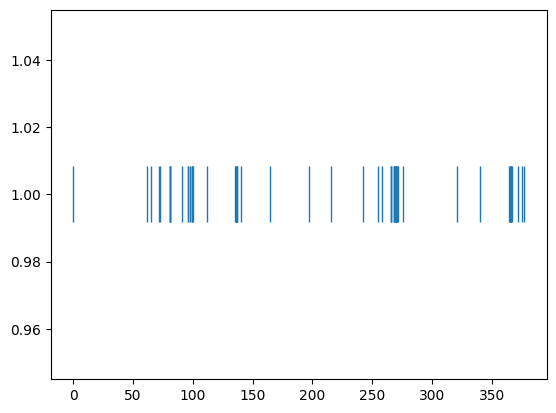

In [149]:
y = np.ones(np.shape(list_times))   # Make all y values the same
plt.plot(list_times, y, '|', ms = 40)  # Plot a line at each location specified in a
# plt.axis('off')
plt.show()

In [91]:
def gen_result(list_data, n_clusters):
    model = Doc2Vec(vector_size=50, min_count=2, epochs=40)
    model.build_vocab(list_data)
    model.train(list_data, total_examples=model.corpus_count, epochs=model.epochs)

    kmeans_model = KMeans(n_clusters=n_clusters, init="k-means++", max_iter=100) 
    X = kmeans_model.fit(model.dv.vectors)
    labels=kmeans_model.labels_.tolist()
    l = kmeans_model.fit_predict(model.dv.vectors)
    pca = PCA(n_components=2).fit(model.dv.vectors)
    datapoint = pca.transform(model.dv.vectors)

    label1 = ["#FF0000", "#00FF00", "#0000FF", 
              "#FF00FF", "#00FFFF", "#FFFF00", 
              "#FFF000", "#FF00F0", "#F0FF00", "#00FFF0"]
    color = [label1[i] for i in labels]
    plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
    centroids = kmeans_model.cluster_centers_
    centroidpoint = pca.transform(centroids)
    plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker="^", s=150, c="#000000")
    plt.show()

    return centroidpoint, datapoint, color

In [92]:
def calc_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2)**2))

In [93]:
def cos_similiarity(v1, v2):
    dot_product = np.dot(v1, v2)
    l2_norm = (np.sqrt(sum(np.square(v1)))*np.sqrt(sum(np.square(v2))))
    similarity = dot_product/l2_norm

    return similarity

In [94]:
def print_near_comments(centers, points, colors, raw_comments, fn_distance):
    for idx in range(len(centers)):
        distances = [fn_distance(centers[idx], point) for point in points]

        if fn_distance is cos_similiarity:
            sorted_indices = np.argsort(np.argsort(distances)[::-1])
        else:
            sorted_indices = np.argsort(np.argsort(distances))

        print(f"{centers[idx]}와 가까운 댓글")

        for i in range(15):
            print("F" if distances[np.where(sorted_indices == i)[0][0]] > 0.1 else "T",
                  raw_comments[np.where(sorted_indices == i)[0][0]], 
                  distances[np.where(sorted_indices == i)[0][0]], 
                  colors[np.where(sorted_indices == i)[0][0]])

        print()

# Original Comments k-means

/opt/anaconda3/envs/NLP/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/envs/NLP/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


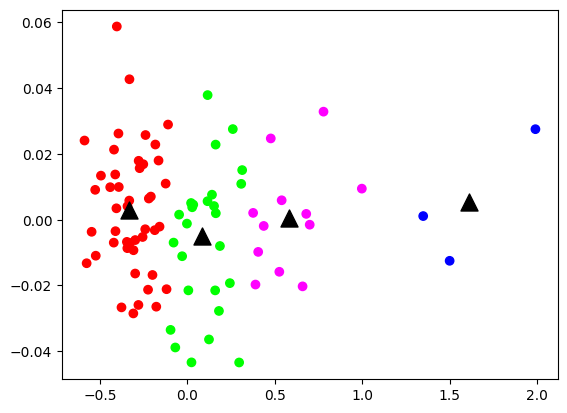

In [95]:
center_origin, point_origin, color = gen_result(list_origin_comments, 4)

In [96]:
print("near points")
print_near_comments(center_origin, point_origin, color, list_origin_comments_raw, calc_distance)

near points
[1.612306   0.00538029]와 가까운 댓글
F ('무삭제판인 이유 : 첫 장기연애 영상에 가방 놔두고 간 거 여기선 마지막에 진짜 김원훈 나와서 가방 가지고 가는 거  멀티버스냐고 ', 4) 0.114510246 #0000FF
F (' 아니 원훈이 형인줄 알고 그냥 보고있었는데 장면 바뀌고 3초있다가 엉? 하고 바뀜 웃긴게 마지막은 2:49 원훈이형임 ', 4) 0.2643469 #0000FF
F ('한석준 님이네요???!!!  대박!!! 석준 님이랑 원훈 님이랑 진짜 똑닮. 썸넬에선 인지 못 했고 영상 켜고도 몇 초간은 긴가민가 했는데 오호. 02:49 원훈 님', 4) 0.37806726 #0000FF
F ('왜 무삭제판인거죠?? 설마 한석준? 하면서 봤는데... 진짜였어요?:?', 4) 0.6151836 #FF00FF
F ('아 뭔가 했더니  2:50 쯤에 한석준님에 게스트로 출연하시네요', 4) 0.8347597 #FF00FF
F ('2:50 밥 다 먹고 마지막에 가방 가져가는건 원훈이 형이네 ㄷㄷ', 4) 0.91321176 #FF00FF
F ('썸네일:오늘은 또김원훈 뭐하려나~클릭후:?? 그새 늙었나', 4) 0.9331026 #FF00FF
F ('2:51 여기서 남자 주인공 잠깐 바뀐거 같은데 뭐죠', 4) 0.9543044 #FF00FF
F ('썸네일만 보고 그냥 원훈님인줄...:::!!!!', 4) 1.0736006 #FF00FF
F ('2:49 김원훈님 얼굴 성형한줄알았는데 아니였구나', 4) 1.0871654 #FF00FF
F ('2:50 이거는 원훈님 맞죠?  진짜 너무 비슷하시당', 4) 1.1360039 #FF00FF
F ('2:51마지막 가방갖고갈때 원훈이형으로 바뀌는거 아무도 언급안하냐고', 4) 1.1761689 #FF00FF
F ('영상 본지 2:59초 때 원훈이 형이 아니란걸 알았다...', 4) 1.2078584 #FF00FF
F ('1:43드럽게먹엇어. 1:51아까똥쌋자나. 아무렇지 않게

# Violation Comments k-means

/opt/anaconda3/envs/NLP/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/envs/NLP/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


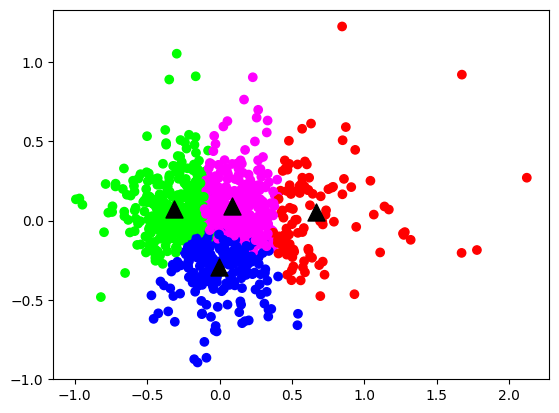

In [97]:
center_shorts, point_shorts, color = gen_result(list_shorts_comments, 4)

In [98]:
print_near_comments(center_shorts, point_shorts, color, list_shorts_comments_raw, calc_distance)

[0.08484087 0.08987223]와 가까운 댓글
T ('우와~~~~~~~~~ 진짜 깜놀', 4) 0.007319038 #FF00FF
T ('홀란드 폼 미쳤다 ㄷㄷㄷ', 4) 0.008502236 #FF00FF
T ('눈썹문신 이상해', 4) 0.020028086 #FF00FF
T ('손님 가방가져가세요', 4) 0.02836258 #FF00FF
T ('아니ㄱ재능무엇', 4) 0.03339627 #FF00FF
T ('있다 키스할거야? 상황봐서라는 대답나올줄은 몰랐다', 4) 0.03369173 #FF00FF
T ('구분이 안됨 ', 4) 0.035587803 #FF00FF
T ('와 똑같애  소오름ㅁ', 4) 0.04210953 #FF00FF
T (' 그냥보다가 깜놀~^^', 4) 0.04231544 #FF00FF
T ('아~~~어떻게 ㅎ', 4) 0.042818014 #FF00FF
T ('절대 안저러는데 ㅜㅜ', 4) 0.043523584 #FF00FF
T ('심지어 목소리도 비슷하네 제목보고 언제 나오지 하고 기다렸다ㄷㄷ 개똑같누', 4) 0.04396251 #FF00FF
T ('키...키스?', 4) 0.0444184 #FF00FF
T ('남자가 바꼈는데 안바꼈어', 4) 0.045777183 #FF00FF
T ('연애 9년차인데  바이브 공감갑니다', 4) 0.046552453 #FF00FF

[-0.00242268 -0.29398555]와 가까운 댓글
T ('한참 보고 사람바뀐거 알았네', 4) 0.019697003 #0000FF
T ('이거 본 거 같은데...하다가 거의 끝날때쯤 제목보고 알았네...헐...', 4) 0.031396594 #0000FF
T ('대박...몰랐음... 2번째 보고 제목의 뜻을 알았음', 4) 0.031880386 #0000FF
T ('원훈이형 어디 고쳤어요? 얼굴에 좀 바뀐듯', 4) 0.042910807 #0000FF
T ('뭔 상황인지는 모르겠으나 첨에 한석준 아나운서밖에 안보였는데 뭐가 뭐임???', 4) 0